# Comparison of northern boundary forcing options against TPXO and ATG data

In [22]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

src_dir = os.environ.get('srcdir')
print(src_dir)

sys.path.append(src_dir)

# always reload modules marked with "%aimport"
%load_ext autoreload
%autoreload 1

%aimport features.grid_ttide
%aimport features.compare_tide
from features.grid_ttide import grid_ttide, plot_M2O1_diff
from features.compare_tide import compare_tide

/home/ubuntu/bigStick/tidal_melting/src
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
def plot_max_ampl(case_max_ampl_da,case_str,ref_max_ampl,ref_str):
    plt.clf()
    fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(17,4))
    fig.suptitle('Comparison of maximum tidal height amplitude ROMS vs. TPXO7.2',fontsize=16)
    ref_max_ampl.fillna(0).plot(ax=ax1,vmax=4)
    ax1.set_title(ref_str+' [m]')
    ax1.axis('off')
    
    case_max_ampl_da.fillna(0).plot(ax=ax2,vmax=4)
    ax2.set_title(case_str+ ' [m]')
    ax2.axis('off')
    tpxo_ampl_max.tide_Eamp.plot(ax=ax3,vmax=4)
    ax3.set_title('TPXO (theoretical)')
    ax3.axis('off')
    plt.show()

In [25]:
# load tpxo forcing amplitude and phase information as Xarray dataset
def plot_M2O1(case_ds,case_str,ds_ref,ref_str):
    plt.close('all')
    fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(17,8))
    ax1,ax2,ax3,ax4,ax5,ax6 = axes.flatten()
    fig.suptitle('Comparison of M2 and O1 height amplitude',fontsize=16)

    ds_ref.M2_ampl.fillna(0).plot(ax=ax1,vmax=1.5)
    ax1.set_title(ref_str+' [m]')
    ax1.axis('off')

    case_ds.M2_ampl.fillna(0).plot(ax=ax2,vmax=1.5)
    ax2.set_title(case_str +' [m]')
    ax2.axis('off')

    dsf.tide_Eamp[0].plot(ax=ax3,vmax=1.5)
    ax3.set_title('TPXO M2 amplitude in m')
    ax3.axis('off')


    ds_ref.O1_ampl.fillna(0).plot(ax=ax4,vmax=0.5)
    ax4.set_title(ref_str+' [m]')
    ax4.axis('off')

    case_ds.O1_ampl.fillna(0).plot(ax=ax5,vmax=0.5)
    ax5.set_title(case_str+' [m]')
    ax5.axis('off')

    dsf.tide_Eamp[5].plot(ax=ax6,vmax=1.5)
    ax6.set_title('TPXO O1 amplitude in m')
    ax6.axis('off')

    plt.show()

## SSH and UV alone

In [29]:
# load tpxo forcing amplitude and phase information as Xarray dataset
tpxo_path = os.path.join(os.environ.get('rawdir'),'waom10_full_forcing','Data','waom10','waom10_tds_large.nc')
dsf = xr.open_mfdataset(tpxo_path)

# calculate the superposition of amplitudes of all constituents (max tidal amplitude possible)
tpxo_ampl_max = dsf.sum('tide_period')

In [27]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_SSH','ocean_his_0006.nc')
ds_SSH = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
SSH_maxAmpl = ds_SSH.zeta[336:].max('ocean_time')-ds_SSH.zeta[336:].mean('ocean_time')

CPU times: user 47.1 s, sys: 9.9 s, total: 57 s
Wall time: 54.4 s


In [43]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_UV','ocean_his_0002.nc')
ds_UV = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
UV_maxAmpl = ds_UV.zeta[336:].max('ocean_time')-ds_UV.zeta[336:].mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


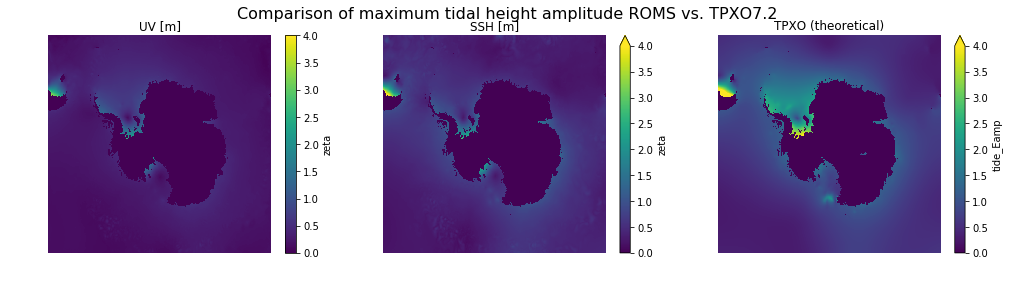

In [29]:
plot_max_ampl(SSH_maxAmpl,'SSH',UV_maxAmpl,'UV')

In [27]:
ds_SSH = grid_ttide(ds_SSH.zeta,ds_SSH,50)
ds_UV = grid_ttide(ds_UV.zeta,ds_UV,50)

setting up the new fields  ['amp', 'amp_err', 'phase', 'phase_err']  for  ['O1', 'M2']
applying t_tide to every  50 th cell ...


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

interpolating intermediate cells and mask land


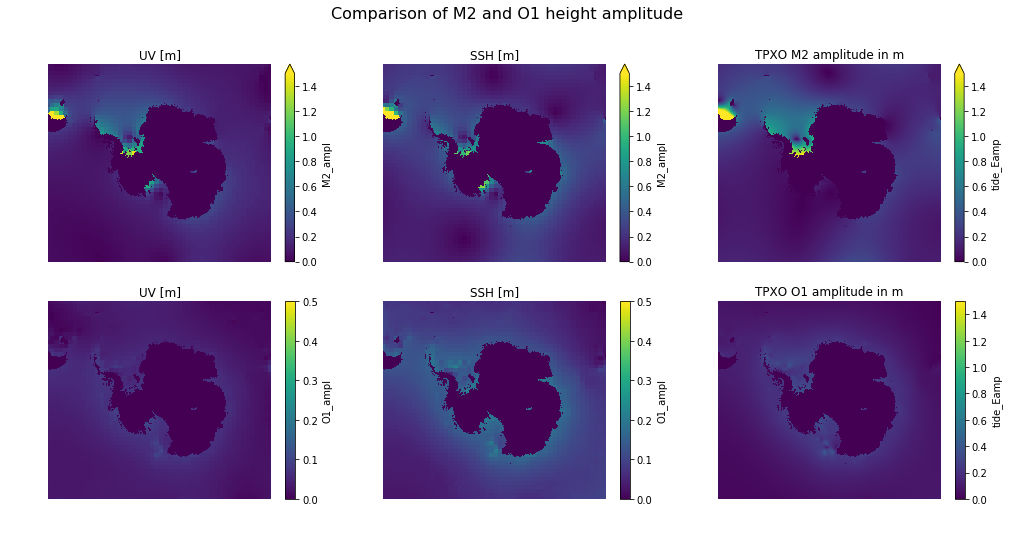

In [32]:
plot_M2O1(ds_SSH,'SSH',ds_UV,'UV')

## SSHUV and SSHUVPOT

In [33]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_SSHUV','ocean_his_0002.nc')
ds_SSHUV = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
SSHUV_maxAmpl = ds_SSHUV.zeta[336:].max('ocean_time')-ds_SSHUV.zeta[336:].mean('ocean_time')

In [34]:
#look at results
file_path = os.path.join(os.environ.get('rawdir'),'waom10_SSHUVPOT','ocean_his_0002.nc')
ds_SSHUVPOT = xr.open_mfdataset(file_path)

# calculate maximum anomaly of the free surface height compared to the 14 day mean
SSHUVPOT_maxAmpl = ds_SSHUVPOT.zeta[336:].max('ocean_time')-ds_SSHUVPOT.zeta[336:].mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


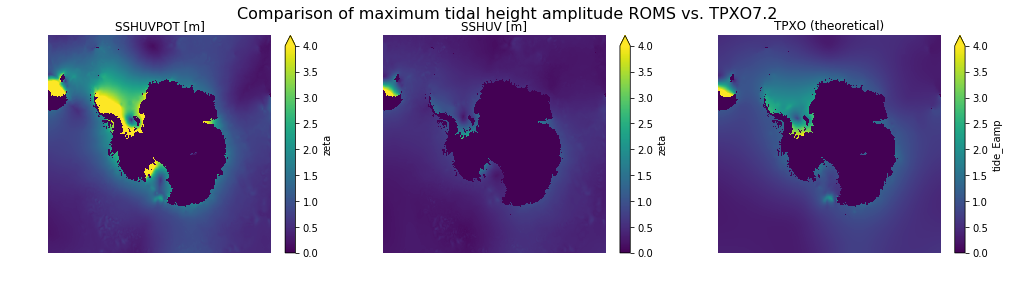

In [35]:
plot_max_ampl(SSHUV_maxAmpl,'SSHUV',SSHUVPOT_maxAmpl,'SSHUVPOT')

In [ ]:
ds_SSHUV = O1_M2_ampl(ds_SSHUV,ds_SSHUV,50)
ds_SSHUVPOT = O1_M2_ampl(ds_SSHUVPOT,ds_SSHUVPOT,50)

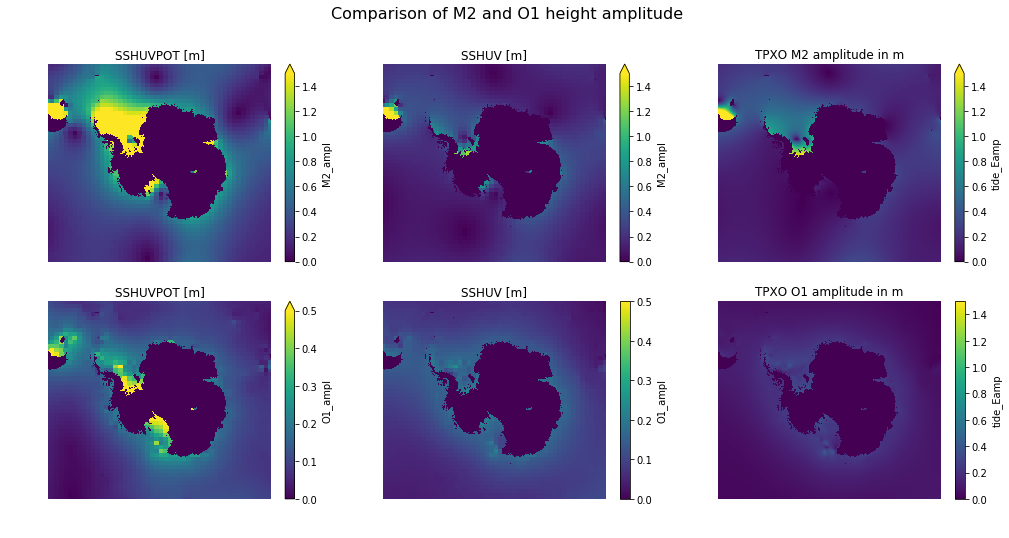

In [38]:
plot_M2O1(ds_SSHUV,'SSHUV',ds_SSHUVPOT,'SSHUVPOT')

## Large scale circulation of SSH and UV alone, and SSHUV

In [2]:
import xarray as xr
import os
import sys

src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)
from visualization.plot_barotropic_xr import plot_uv


# always reload modules marked with "%aimport"
%load_ext autoreload
%autoreload 1
%aimport visualization.plot_barotropic_xr

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


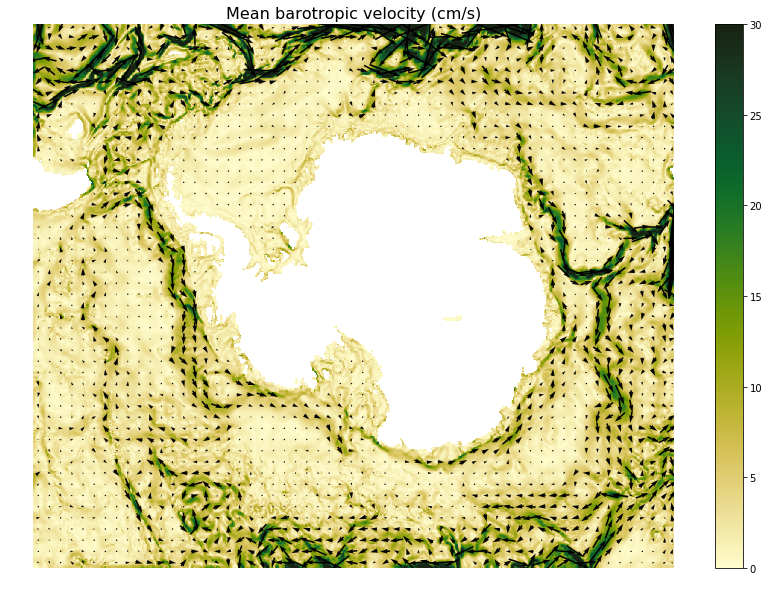

In [6]:
file_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_SSH','ocean_avg_uv_0001.nc')
ds = xr.open_mfdataset(file_path)
plot_uv(ds.mean('ocean_time'))

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


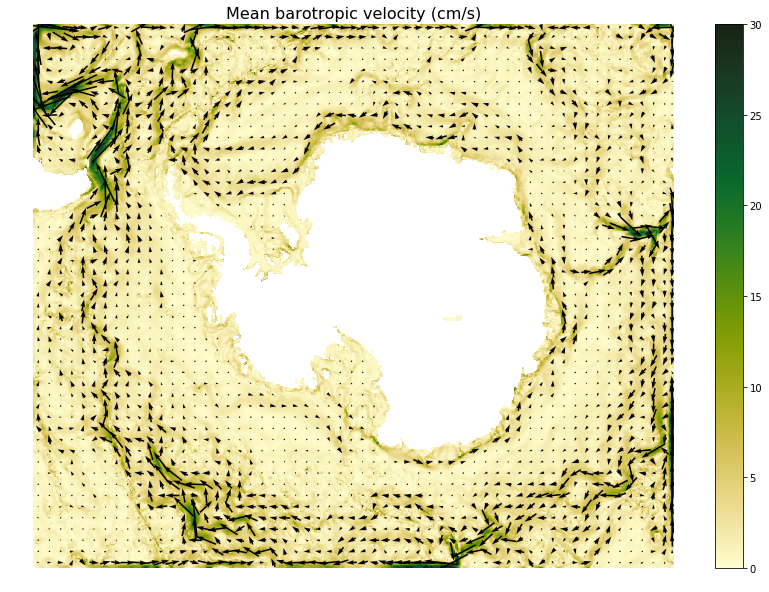

In [42]:
file_path = os.path.join(os.environ.get('rawdir'),'waom10_UV','ocean_avg_uv_0002.nc')
ds = xr.open_mfdataset(file_path)
plot_uv(ds.mean('ocean_time'))

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


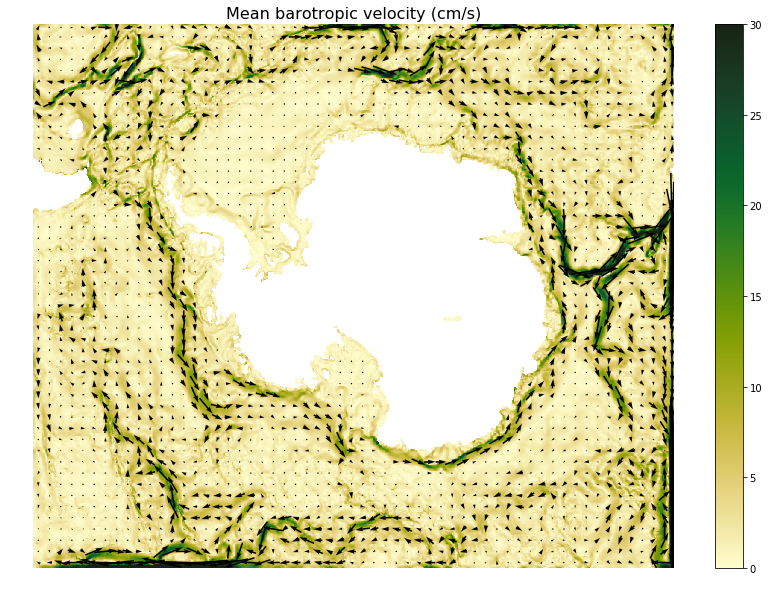

In [7]:
file_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_SSHUV','ocean_avg_uv_0002.nc')
ds = xr.open_mfdataset(file_path)
plot_uv(ds.mean('ocean_time'))

## Closer look at UV alone tides

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


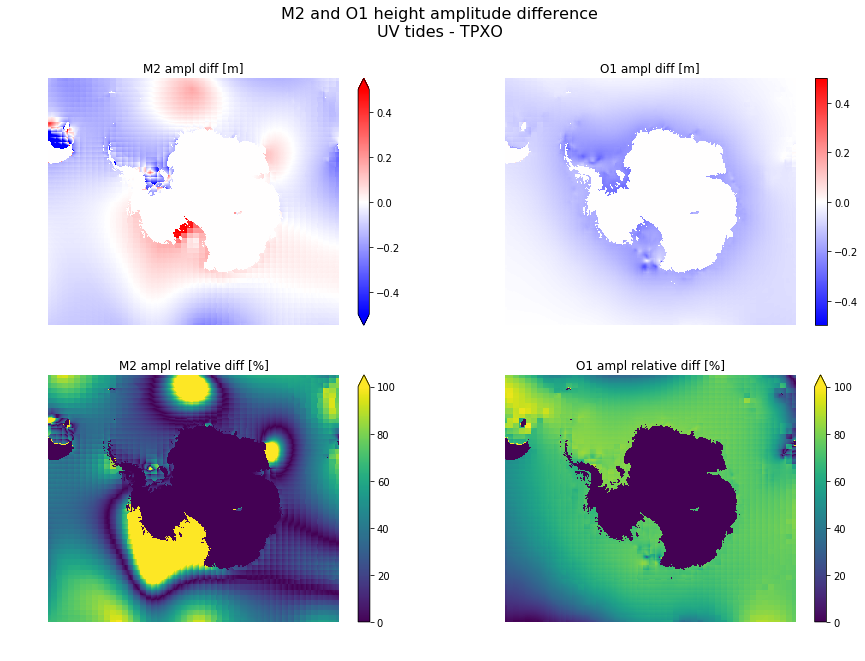

In [31]:
plot_M2O1_diff(ds_UV,'UV tides',dsf,'TPXO',vmin=-0.5,vmax=0.5)

In [32]:
stations,RMSE = compare_tide(ds_UV.zeta,ds_UV.mask_rho)

stime =  2007-01-01 00:00:00  constits =  ['M2', 'O1'] stations =  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108]


VBox(children=(HTML(value=''), IntProgress(value=0, max=108)))

Station ID || Amp(amp_err)[m]:  atg   roms || phase(phase_err)[deg]:  atg   roms || Station Name; RecLen [days]; Nearest Neibour [km]
M2
1 || 0.19  0.06(0.01)  || 287.87  110.34(12.64)  ||  faraday   365.0  0.85
2 || 0.34  0.42(0.04)  || 197.87  12.25(5.50)  ||  forster   307.25  0.83
3 || 0.12  0.04(0.03)  || 265.51  327.91(42.78)  ||  Rothera   365.0  1.29
4 || 0.45  0.33(0.03)  || 264.06  57.55(5.51)  ||  Signy   385.0  0.58
5 || 0.49  0.26(0.02)  || 280.00  104.33(7.17)  ||  PTC_4_2_01   4.2  0.18
6 || 0.53  0.42(0.04)  || 233.00  45.74(5.54)  ||  PTC_4_2_02   30.0  1.08
7 || 0.57  0.44(0.04)  || 242.00  45.31(5.50)  ||  PTC_4_2_03   180.0  0.48
8 || 0.41  0.41(0.04)  || 189.00  4.84(6.04)  ||  PTC_4_2_05 Georg Von Neumayer   324.0  0.37
9 || 0.46  0.43(0.04)  || 201.00  12.29(5.85)  ||  PTC_4_2_06 Kapp Norvegia   367.0  0.71
10 || 0.56  0.48(0.04)  || 220.00  24.63(5.57)  ||  PTC_4_2_07 Vestkapp   316.0  0.56
11 || 0.40  0.26(0.03)  || 274.00  77.96(6.03)  ||  PTC_4_2_12 Signy Lin

96 || 0.28  0.06(0.01)  || 0.21  290.41(11.84)  ||  Larsen C GPS LAR3 (inference from LAR2)   64.0  0.43
97 || 0.28  0.06(0.01)  || 354.28  292.09(11.94)  ||  Larsen C GPS SLGN1 (inference from LAR2)   38.0  0.49
98 || 0.28  0.06(0.01)  || 354.01  292.09(10.58)  ||  Larsen C GPS SLGS1 (inference from LAR2)   36.0  0.07
99 || 0.32  0.07(0.01)  || 351.61  289.32(13.51)  ||  Larsen C Mobil Oil Inlet (inf. from LAR2)   41.0  0.21
100 || 0.29  0.07(0.01)  || 99.37  26.84(8.02)  ||  Tide_Dotson.mat   373.0  1.05
101 || 0.29  0.07(0.01)  || 102.70  33.58(7.41)  ||  Tide_GetzCtrl.mat   364.0  0.69
102 || 0.29  0.07(0.01)  || 100.62  31.31(7.38)  ||  Tide_GetzEast.mat   372.0  0.43
103 || 0.29  0.07(0.01)  || 95.79  21.07(6.87)  ||  Tide_PineIsland.mat   354.0  0.91
104 || 0.28  0.07(0.01)  || 90.80  21.53(7.12)  ||  Pine Island GPS   52.0  0.36
105 || 0.40  0.06(0.01)  || 62.23  357.88(27.63)  ||  Evans Ice Stream GPS: EE2B   94.0  0.53
106 || 0.14  0.06(0.02)  || 63.72  355.41(17.67)  ||  Eva